## Importing libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_curve, auc

# plt.style.use('dark_background')

## 1. Loading data

### 1.1. Read data

In [2]:
bank_data = pd.read_csv('../data/data.csv')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
bank_data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

In [6]:
bank_data.shape

(6819, 96)

#### It seems that the dataset has been scaled, let's check this

In [5]:
(np.max(bank_data, axis=0) > 0.999).sum()

96

In [6]:
(np.min(bank_data, axis=0) < 0.001).sum()

95

$\Rightarrow$ We can see that the dataset has been scaled

## 2. EDA

### 2.1. Check data information

In [8]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

Through data.info(), we observed that we have a majority of "float64" data. The categorical data is distinguished as binary 1 and 0, thus stored as "int64". So, we first analize three features which datatype are "int64"

### 2.2. Features Overview

In [9]:
strange_features = bank_data.dtypes[bank_data.dtypes == "int64"].index
numeric_features = bank_data.dtypes[bank_data.dtypes == "float64"].index

print(bank_data[strange_features].columns.tolist())
print(len(strange_features))
print(len(numeric_features))

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']
3
93


#### 2.2.1. Liability-Assets Flag compared to Bankrupt

 Liability-Assets Flag  Bankrupt?
0                       0            6597
                        1             214
1                       1               6
                        0               2
dtype: int64


<AxesSubplot:xlabel=' Liability-Assets Flag', ylabel='count'>

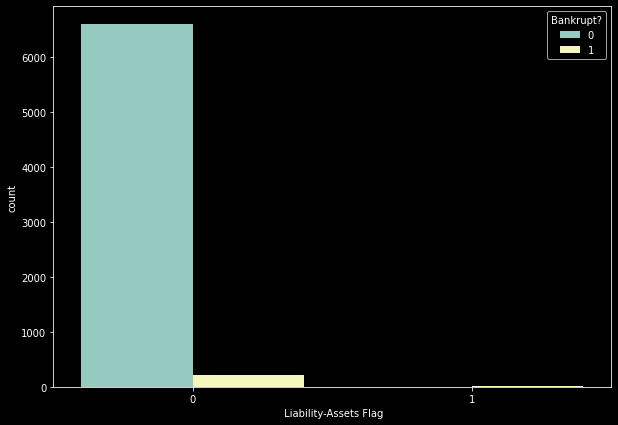

In [18]:
print(bank_data[[" Liability-Assets Flag", "Bankrupt?"]].value_counts())
print("=======================")
plt.figure(figsize=(10, 7))
sns.countplot(x=" Liability-Assets Flag", hue="Bankrupt?", data=bank_data)

Explaination of `Liability-Assets`:
+ The `Liability-Assets` flag denotes the status of an organization, where if the `total liability exceeds total assets`, the flagged value will be 1, else the value is 0. A majority number of times, organizations/company's assets are more than their liabilities.

Brief:
+ A small portion of organizations suffers bankruptcy, although possessing more assets than their liabilities.

#### 2.2.2. Net Income Flag compared to Bankrupt

 Net Income Flag  Bankrupt?
1                 0            6599
                  1             220
dtype: int64


<AxesSubplot:xlabel=' Net Income Flag', ylabel='count'>

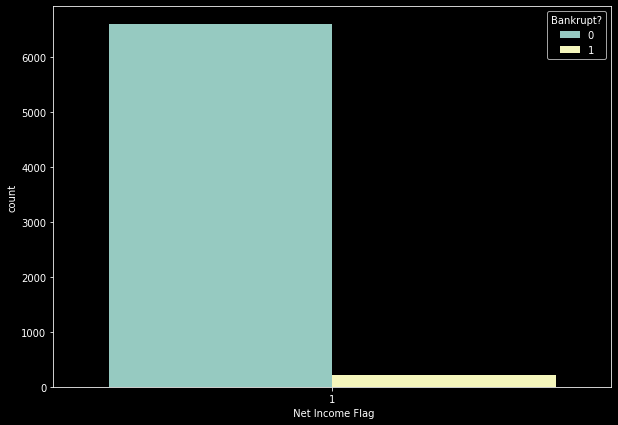

In [19]:
print(bank_data[[" Net Income Flag", "Bankrupt?"]].value_counts())
print("=======================")
plt.figure(figsize=(10, 7))
sns.countplot(x=" Net Income Flag", hue="Bankrupt?", data=bank_data)

Explaination of `Net Income`:
+ The `Net Income` flag denotes the `status of an organization's income` in the last two years, where if the net income is negative for the past two years, the flagged value will be 1, else the value is 0. We observe that all the records have been exhibiting a loss for the past two years.

Brief:
* Many organizations that have suffered losses for the past two years have stabilized their business, thus avoiding bankruptcy.

## 3. Details analysis

### 3.1. Data description

In [12]:
bank_data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


### 3.2. Checking NAN

In [13]:
[col for col in bank_data if bank_data[col].isnull().sum() > 0]

[]

$\Rightarrow$ There's no missing data

### 3.3. Checking duplicates

In [14]:
bank_data.duplicated().sum()

0

$\Rightarrow$ There's no duplicated rows

### 3.4. Checking objective column

In [15]:
bank_data['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [16]:
print(f"Financially stable: {round(bank_data['Bankrupt?'].value_counts()[0]/len(bank_data) * 100,2)} %")
print(f"Financially unstable: {round(bank_data['Bankrupt?'].value_counts()[1]/len(bank_data) * 100,2)} %")

Financially stable: 96.77 %
Financially unstable: 3.23 %


d:\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Class Distributions \n (0: Financially Stable || 1: Financially Unstable)')

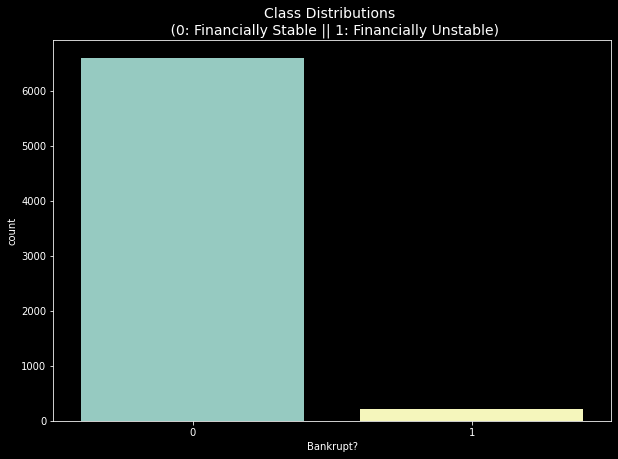

In [20]:
plt.figure(figsize=(10, 7))
sns.countplot(bank_data['Bankrupt?'])
plt.title('Class Distributions \n (0: Financially Stable || 1: Financially Unstable)', fontsize=14)

$\Rightarrow$ We see that the dataset is highly imbalanced

### 3.5. Seeing correlations between features and target column

We analyze the ten top positively and negatively correlated attributes.

In [13]:
positive_corr = bank_data[numeric_features].corrwith(bank_data["Bankrupt?"]).sort_values(ascending=False)[:10].index.tolist()
negative_corr = bank_data[numeric_features].corrwith(bank_data["Bankrupt?"]).sort_values()[:10].index.tolist()
positive_corr_df = bank_data[positive_corr + ["Bankrupt?"]]
negative_corr_df = bank_data[negative_corr + ["Bankrupt?"]]

In [14]:
def corr_barplot(x_value, y_value):
    plt.figure(figsize=(10, 14))
    for i in range(1, 11):
        plt.subplot(5, 2, i)
        sns.barplot(x=x_value, y=y_value[i - 1], data=bank_data)

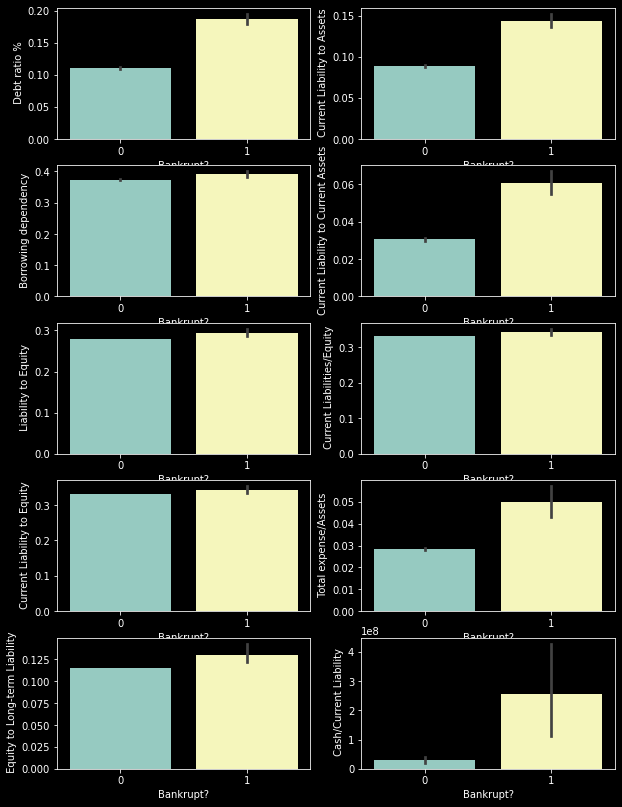

In [21]:
x_value = positive_corr_df.columns.tolist()[-1]
y_value = positive_corr_df.columns.tolist()[:-1]
corr_barplot(x_value, y_value)

$\Rightarrow$ We see that three attributes - `Debt Ratio %`, `Current Liability To Assets`, `Current Liability To Current Assets` are commonly high in bankrupt organizations

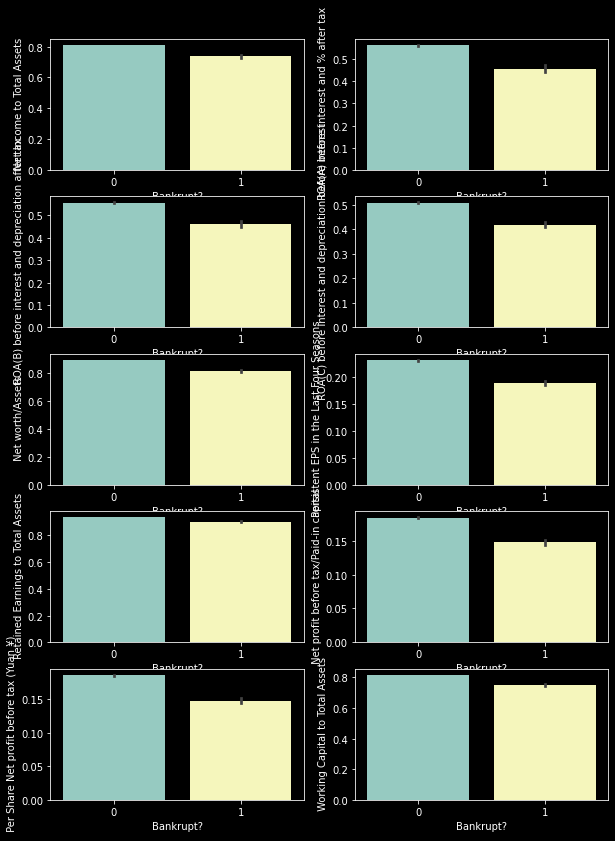

In [22]:
x_value = negative_corr_df.columns.tolist()[-1]
y_value = negative_corr_df.columns.tolist()[:-1]

corr_barplot(x_value, y_value)

These attributes show us that the more the `assets` and `earing of a company`, the less likely is `the organization to be bankrupt`.

Let us check the relation of top six positive and negative correlation attributes among eachother

<AxesSubplot:>

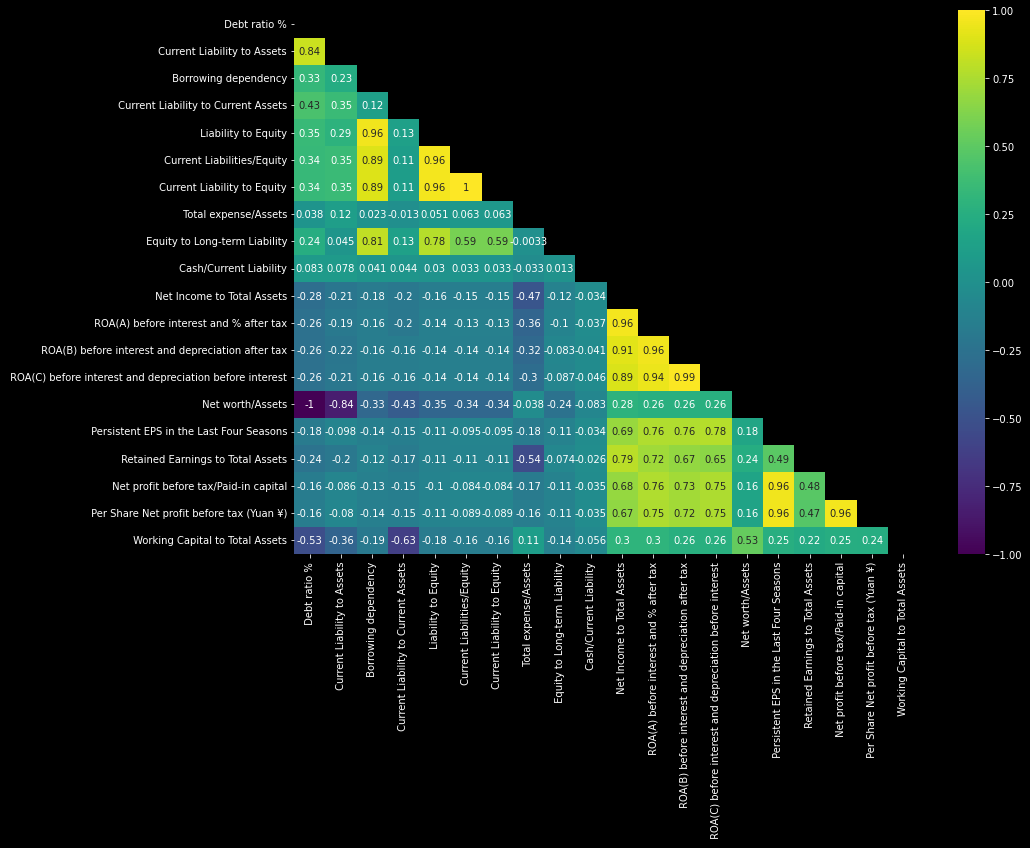

In [23]:
relation = positive_corr + negative_corr
plt.figure(figsize=(14, 10))
mask = np.zeros_like(bank_data[relation].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(bank_data[relation].corr(), mask=mask, annot=True, cmap='viridis')

## 4. Data processing

### 4.0. Prepare parameters

In [ ]:
param_grid = {}

### 4.1. Outliers removal

In [23]:
# Don't run this cell, it is used for testing only
# Outliers removal

def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

new_data = bank_data

for col in bank_data:
    new_data = outliers_removal(new_data[col], str(col), new_data)

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt? Lower: 0.0
Bankrupt? Upper: 0.0
Bankrupt? outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
Quartile 25: 0.47862331204602 | Quartile 75: 0.537074050602057
iqr: 0.05845073855603705
Cut Off: 0.08767610783405558
 ROA(C) before interest and depreciation before interest Lower: 0.3909472042119644
 ROA(C) before interest and depreciation before interest Upper: 0.6247501584361126
 ROA(C) before interest and depreciation before interest outliers for close to bankruptcy cases: 345
-----------------------------------------------------------------
Quartile 25: 0.5386093545573485 | Quartile 75: 0.587549062363716
iqr: 0.04893970780636747
Cut Off: 0.07340956170955121
 ROA(A) before interest and % after tax Lower: 0.4651997928477973
 ROA(A) before interest and % after tax Upper: 0.6609586240732672
 ROA(A) before interest and % after tax outliers for close to bankruptcy cases:

### 4.2. Dimentional Reduction

#### PCA

In [ ]:
pca = ('pca', PCA())
param_grid['pca__n_components']                 =  [10, 15, 20, 25, 30]
param_grid['pca__svd_solver']                   =  ['auto', 'full', 'arpack', 'randomized']
param_grid['pca__n_oversamples']                =  [10, 15, 20, 25, 30]
param_grid['pca__power_iteration_normalizer']   =  ['auto', 'QR', 'LU', 'none']

#### LinearDiscriminantAnalysis

In [ ]:
lda = ('lda', LinearDiscriminantAnalysis())
param_grid['lda__solver']                      = ['svd', 'lsqr', 'eigen']
param_grid['lda__shrinkage']                   = []
param_grid['lda__n_components']                = [10, 15, 20, 25, 30]

#### Isomap

In [ ]:
iso = ('iso', Isomap())
param_grid['iso__n_neighbors']          = [5, 10, 15, 20, 25]
# param_grid radius
param_grid['iso__n_neighbors']          = [5, 10, 15, 20, 25]
param_grid['iso__n_components']         = [2, 4, 6, 8, 10]
param_grid['iso__eigen_solver']         = ['auto', 'arpack', 'dense']
param_grid['iso__neighbors_algorithm']  = ['auto', 'brute', 'kd_tree', 'ball_tree']

#### LocallyLinearEmbedding

In [24]:
lle = ('lle', LocallyLinearEmbedding())
param_grid['lle__n_neighbors'] = [5, 10, 15, 20, 25]
param_grid['lle__n_components'] = [2, 4, 6, 8, 10]
param_grid['lle__eigen_solver'] = ['auto', 'arpack', 'dense']
param_grid['lle__neighbors_algorithm']  = ['auto', 'brute', 'kd_tree', 'ball_tree']

In [ ]:
# mlle = ('lle', LocallyLinearEmbedding(method='modified'))

### 4.3. Handling imbalanced data

#### SMOTE

In [ ]:
over = ('over', SMOTE())
param_grid['over__sampling_strategy']   = [0.5, 0.75, 1.0]
param_grid['over__k_neighbors']         = [5, 8, 10, 12]

#### RandomUnderSampler

In [ ]:
under               = ('under', RandomUnderSampler())
param_grid['under__sampling_strategy']   = [0.5, 0.75, 1.0]

#### BorderlineSMOTE

In [ ]:
borderline_smote    = ('borderline_smote', BorderlineSMOTE())
param_grid['borderline_smote__sampling_strategy']   = [0.5, 0.75, 1.0]
param_grid['borderline_smote__k_neighbors']         = [5, 8, 10, 12]
param_grid['borderline_smote__m_neighbors']         = [10, 12, 15, 18]
param_grid['borderline_smote__kind']                = ["borderline-1", "borderline-2"]

#### SVMSMOTE

In [ ]:
svm_smote           = ('svm_smote', SVMSMOTE())
param_grid['svm_smote__sampling_strategy']   = [0.5, 0.75, 1.0]
param_grid['svm_smote__k_neighbors']         = [5, 8, 10, 12]
param_grid['svm_smote__m_neighbors']         = [10, 12, 15, 18]

#### ADASYN

In [25]:
adasyn              = ('adasyn', ADASYN())
param_grid['adasyn__sampling_strategy'] = [0.5, 0.75, 1.0]
param_grid['adasyn__n_neighbors']       = [5, 7, 10, 12]

## 5. Building pipeline

In [26]:
# Features and label
features = bank_data.columns[1:]
X = bank_data[features]
y = bank_data["Bankrupt?"]

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)

In [28]:
# Add more models here
svm = ('svm', SVC(cache_size=10000))
param_grid['svm__C']                = [0.01, 0.1, 1, 10]
param_grid['svm__gamma']            = [0.1, 0.01, 0.001, 0.0001]
param_grid['svm__kernel']           = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

In [34]:
# Testing components of pipeline to obtain best model
pipe = Pipeline(steps=[pca, over, svm])

In [36]:
# Grid Search
search = GridSearchCV(pipe, param_grid, n_jobs=4)

## 6. Training and Evaluation

In [37]:
search.fit(X_train, y_train)

In [ ]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)

In [ ]:
best_model = search.best_estimator_

We should fine tune the best model again here

In [ ]:
# Prediction
y_pred = best_model.predict(X_test)

In [ ]:
# Evaluation
result = classification_report(y_test, y_pred)
print(result)